# **DATA PREPARATION**

In [56]:
!pip install datasets huggingface hub --quiet

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [57]:
from huggingface_hub import login
login("hf_TOKEN")

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


# **MODEL TRAINING**

In [58]:
pip install evaluate --q

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [59]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer

import evaluate
import numpy as np
from transformers import DataCollatorWithPadding

In [60]:
from datasets import load_dataset

dataset_dict = load_dataset("hebashakeel/wellness_project_dataset")

In [61]:
dataset_dict

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 990
    })
    validation: Dataset({
        features: ['text', 'labels'],
        num_rows: 212
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 213
    })
})

**TRAIN TEACHER MODEL**

In [62]:
# Load model directly
model_path = "google-bert/bert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_path)

id2label = {0: "Intellectual Aspect", 1: "Vocational Aspect", 2: "Spiritual Aspect", 3: "Physical Aspect", 4: "Social Aspect", 5: "Emotional Aspect"}
label2id = {"Intellectual Aspect": 0, "Vocational Aspect": 1, "Spiritual Aspect" : 2, "Physical Aspect": 3, "Social Aspect": 4, "Emotional Aspect":5 }

model = AutoModelForSequenceClassification.from_pretrained(model_path, 
                                                           num_labels=6, 
                                                           id2label=id2label, 
                                                           label2id=label2id,)

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [63]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

**Freezing the base model**

In [64]:
# # print layers
# for name, param in model.named_parameters():
#    # print(name, param.requires_grad)

In [65]:
# freeze base model parameters
for name, param in model.base_model.named_parameters():
    param.requires_grad = False

# unfreeze base model pooling layers
for name, param in model.base_model.named_parameters():
    if "pooler" in name:
        param.requires_grad = True

In [66]:
# # print layers
# for name, param in model.named_parameters():
#    print(name, param.requires_grad)

In [67]:
# define text preprocessing
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

In [68]:
# tokenize all datasetse
tokenized_data = dataset_dict.map(preprocess_function, batched=True)

Map:   0%|          | 0/212 [00:00<?, ? examples/s]

In [69]:
# create data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

**EVALUATION**

In [70]:
# load metrics
accuracy = evaluate.load("accuracy")
auc_score = evaluate.load("roc_auc")
precision_score = evaluate.load("precision")
recall_score = evaluate.load("recall")

def compute_metrics(eval_pred):
    # get predictions
    predictions, labels = eval_pred
    
    # apply softmax to get probabilities
    probabilities = np.exp(predictions) / np.exp(predictions).sum(-1, keepdims=True)
    
    # compute AUC for each class in a one-vs-rest fashion
    aucs = []
    for class_idx in range(6): 
        # treat the current class as the "positive" class
        binary_labels = (labels == class_idx).astype(int)
        # use the probability of the current class for AUC calculation
        auc = auc_score.compute(prediction_scores=probabilities[:, class_idx], references=binary_labels)['roc_auc']
        aucs.append(auc)
    # average AUC over all classes
    avg_auc = np.round(np.mean(aucs), 3)
    
    # predict most probable class
    predicted_classes = np.argmax(predictions, axis=1)
    # compute accuracy
    acc = np.round(accuracy.compute(predictions=predicted_classes, references=labels)['accuracy'], 3)
    
    # Compute class-wise precision and recall
    class_precision = {}
    class_recall = {}
    
    for class_idx in range(6):
        tp = np.sum((predicted_classes == class_idx) & (labels == class_idx))  # True Positives
        fp = np.sum((predicted_classes == class_idx) & (labels != class_idx))  # False Positives
        fn = np.sum((predicted_classes != class_idx) & (labels == class_idx))  # False Negatives
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        
        class_precision[f"Precision_Class_{class_idx}"] = np.round(precision, 3)
        class_recall[f"Recall_Class_{class_idx}"] = np.round(recall, 3)
    
    return {
        "Accuracy": acc, 
        "AUC": avg_auc,
        **class_precision,
        **class_recall
    }

**TRAIN MODEL**

In [71]:
# hyperparameters
lr = 1e-4
batch_size = 8
num_epochs = 10

training_args = TrainingArguments(
    output_dir="bert-wellness-classifier",
    learning_rate=lr,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    logging_strategy="epoch",
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

In [72]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_data["train"],
    eval_dataset=tokenized_data["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
) 

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Auc,Precision Class 0,Precision Class 1,Precision Class 2,Precision Class 3,Precision Class 4,Precision Class 5,Recall Class 0,Recall Class 1,Recall Class 2,Recall Class 3,Recall Class 4,Recall Class 5
1,1.652400,1.526751,0.434000,0.755000,0.406000,0.000000,0.000000,0.697000,0.384000,0.000000,0.520000,0.000000,0.000000,0.548000,0.836000,0.000000
2,1.475800,1.405567,0.472000,0.790000,0.382000,1.000000,0.000000,0.646000,0.442000,0.222000,0.520000,0.050000,0.000000,0.738000,0.791000,0.056000
3,1.375200,1.320414,0.533000,0.818000,0.448000,1.000000,0.556000,0.744000,0.466000,0.333000,0.520000,0.250000,0.455000,0.690000,0.821000,0.028000
4,1.293600,1.251876,0.552000,0.837000,0.444000,1.000000,0.467000,0.597000,0.556000,0.250000,0.480000,0.250000,0.318000,0.881000,0.821000,0.028000
5,1.230600,1.200924,0.547000,0.848000,0.464000,0.750000,0.429000,0.773000,0.505000,0.286000,0.520000,0.300000,0.136000,0.810000,0.836000,0.111000
6,1.192500,1.162383,0.590000,0.858000,0.444000,0.833000,0.462000,0.810000,0.593000,0.424000,0.480000,0.250000,0.273000,0.810000,0.806000,0.389000
7,1.148100,1.137763,0.580000,0.862000,0.462000,0.857000,0.438000,0.791000,0.579000,0.360000,0.480000,0.300000,0.318000,0.810000,0.821000,0.250000
8,1.125400,1.125554,0.585000,0.865000,0.480000,0.875000,0.381000,0.795000,0.582000,0.391000,0.480000,0.350000,0.364000,0.833000,0.791000,0.250000
9,1.102000,1.114708,0.585000,0.867000,0.480000,0.875000,0.381000,0.795000,0.582000,0.391000,0.480000,0.350000,0.364000,0.833000,0.791000,0.250000
10,1.100200,1.112203,0.594000,0.868000,0.480000,0.846000,0.368000,0.745000,0.612000,0.391000,0.480000,0.550000,0.318000,0.833000,0.776000,0.250000


TrainOutput(global_step=1240, training_loss=1.2695655084425403, metrics={'train_runtime': 51.7915, 'train_samples_per_second': 191.151, 'train_steps_per_second': 23.942, 'total_flos': 331176212281008.0, 'train_loss': 1.2695655084425403, 'epoch': 10.0})

In [73]:
from transformers import Trainer

# Assuming `trainer` is your Trainer instance and `test_dataset` is your test dataset
test_results = trainer.evaluate(tokenized_data["test"])

# Print the results
print("Test Results on the Best Model:")
for key, value in test_results.items():
    print(f"{key}: {value}")

Test Results on the Best Model:
eval_loss: 1.110676646232605
eval_Accuracy: 0.624
eval_AUC: 0.861
eval_Precision_Class_0: 0.455
eval_Precision_Class_1: 0.75
eval_Precision_Class_2: 0.44
eval_Precision_Class_3: 0.725
eval_Precision_Class_4: 0.675
eval_Precision_Class_5: 0.5
eval_Recall_Class_0: 0.526
eval_Recall_Class_1: 0.522
eval_Recall_Class_2: 0.407
eval_Recall_Class_3: 0.787
eval_Recall_Class_4: 0.812
eval_Recall_Class_5: 0.333
eval_runtime: 0.6309
eval_samples_per_second: 337.602
eval_steps_per_second: 42.795
epoch: 10.0


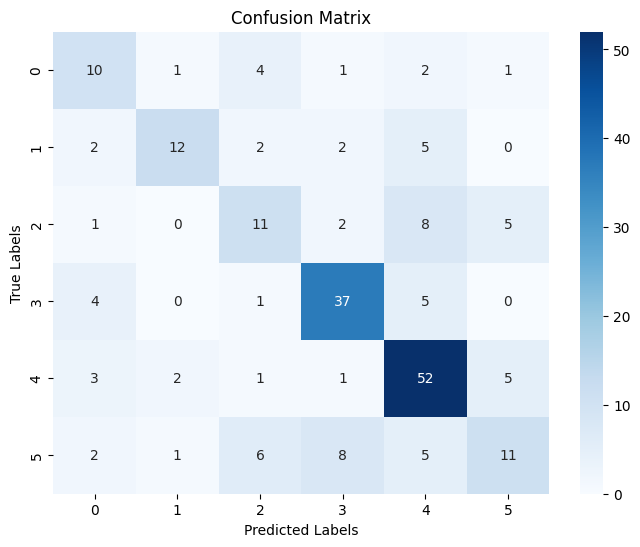

Classification Report:
               precision    recall  f1-score   support

     Class 0       0.45      0.53      0.49        19
     Class 1       0.75      0.52      0.62        23
     Class 2       0.44      0.41      0.42        27
     Class 3       0.73      0.79      0.76        47
     Class 4       0.68      0.81      0.74        64
     Class 5       0.50      0.33      0.40        33

    accuracy                           0.62       213
   macro avg       0.59      0.56      0.57       213
weighted avg       0.62      0.62      0.61       213



In [74]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

predictions = trainer.predict(tokenized_data["test"])

predicted_classes = np.argmax(predictions.predictions, axis=1)
true_labels = predictions.label_ids

conf_matrix = confusion_matrix(true_labels, predicted_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(6), yticklabels=range(6))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Step 3: Print classification report
class_report = classification_report(true_labels, predicted_classes, target_names=[f"Class {i}" for i in range(6)])
print("Classification Report:\n", class_report)

In [75]:
# push model to hub
trainer.push_to_hub()

events.out.tfevents.1739780282.d68c514ae1af.30.11:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Upload 4 LFS files:   0%|          | 0/4 [00:00<?, ?it/s]

events.out.tfevents.1739780230.d68c514ae1af.30.10:   0%|          | 0.00/18.6k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.24k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/hebashakeel/bert-wellness-classifier/commit/6d69c038d978b3c7284b9612df4aa3d0f0f2a23b', commit_message='End of training', commit_description='', oid='6d69c038d978b3c7284b9612df4aa3d0f0f2a23b', pr_url=None, repo_url=RepoUrl('https://huggingface.co/hebashakeel/bert-wellness-classifier', endpoint='https://huggingface.co', repo_type='model', repo_id='hebashakeel/bert-wellness-classifier'), pr_revision=None, pr_num=None)